# A simple model ARMA model with Kalman filter

A collection of simple examples to familiarise myself with statsmodels, will include a simple kalman filter

In [1]:
import numpy as np
print("numpy")
import pandas as pd
print("pandas")
import matplotlib.pyplot as plt
print("matplotlib")

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
print("SARIMAX")
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
print("ACFs")

numpy
pandas
matplotlib
SARIMAX
ACFs


## Simple AR model with white noise

The simplist time series model is the standard AR model with few coeffcients. This class requires that the initial state and k lagged states are explicitly set so that k+1th state can be generated. Additive gaussian noise was introduced to create uncertainty in the time series states. The const value is seperate but should be inluded in the vector product. 

In [2]:
class simpleTimeSeries:
    """ Simple ARMA model with b = 1 and White noise independant of t:
            Y_t+k+1 = const + a*Y_t+k + ... + a*Y_t + W
    """
    
    def generateSeries(self,coeffs,const, initial_state, n, noise_var,seed):
    #Creator function to generate points can be removed from class
    
        
        # Initialise
        data_series = np.zeros(n);
        rng = np.random.RandomState(seed)
        white_noise = rng.normal(0, noise_var, n) 
        k = initial_state.shape[0];
        
        # Set initial states
        for i,ini_val in enumerate(initial_state):
            data_series[i] = ini_val
        
        # Generate proceeding time series states
        for i in range(k,n):
            data_series[i] = np.dot(coeffs, data_series[i-k:i]) + white_noise[i-1] +const
            
        return data_series
    
    def __init__(self, coeffs, const, initial_state, n, noise_var, seed):
        """ Generate time series for model
        
            coeffs:         coeffcients of AR model (smallest delay first)
            const:          AR model constant term
            initial_state:  Given k initial states corresponding to k lags in model
            n:              Number of points to generate (includes initial_states)
            noise_var:      Variance of added white noise (set to 0 to exlude)
            seed:           RNG seed
        """
        self.time_series = self.generateSeries(coeffs,const,initial_state,n,noise_var,seed)
    
    def printSeries(self):
        """ Prints time series
        """
        
        for iter in self.time_series:
            print(iter)
            
    #Create graphing functions that section data in series


An AR(1) model was created but the complexity of an AR(2) was more interesting as a stable AR(1) is just an exponential decay. White noise with a variance of 0.05 was used to represent possible higher order features of the model or error in state measurement.

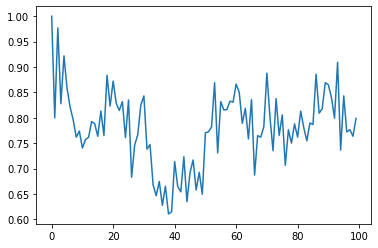

In [3]:
seed = 15
n=100 # number of samples
initial_values = np.array([1,.8])
ar_coeffs = np.array([.8,.2])
ar_const = 0
noise_var = 0.05

double_exp = simpleTimeSeries(ar_coeffs,ar_const,initial_values,n,noise_var,seed) #Y_t = .8*Y_(t-1) + .2*Y_(t-2) + W
data_series = double_exp.time_series
plt.plot(range(n),double_exp.time_series)
endog = pd.DataFrame(data_series,index=range(n)) #Wasted memeory incoporate in class or just use function

# AR(1)
#simple_exp = simpleTimeSeries(np.array([.9]),0,np.array([1]),n,0) #Y_t = .9*Y_(t-1)
#plt.plot(range(n),simple_exp.time_series)

A couple random seeds were tried to get a time series with clear trend. Now since the model is know, we know no difference is required so d = 0 in our ARIMA model. To confirm this we plot the ACF function 

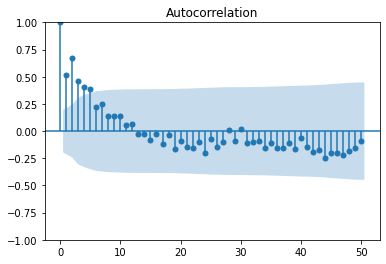

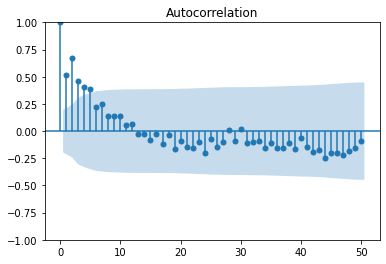

In [4]:
plot_acf(endog, lags=50)

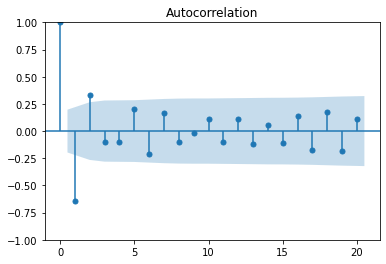

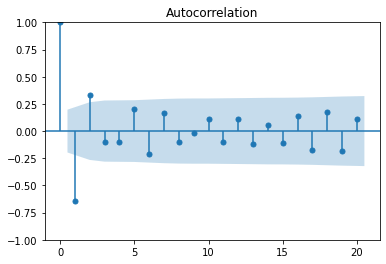

In [5]:
plot_acf(endog.diff().dropna(), lags=20)

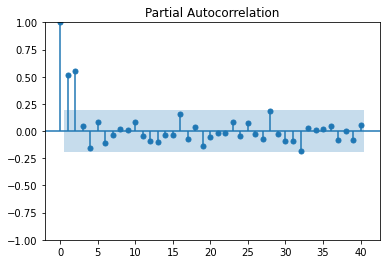

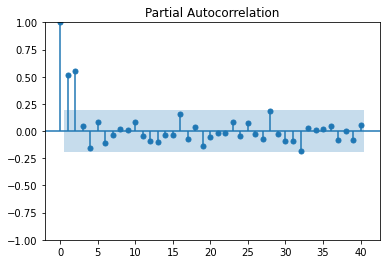

In [6]:
plot_pacf(endog, lags=40, method="ywm")

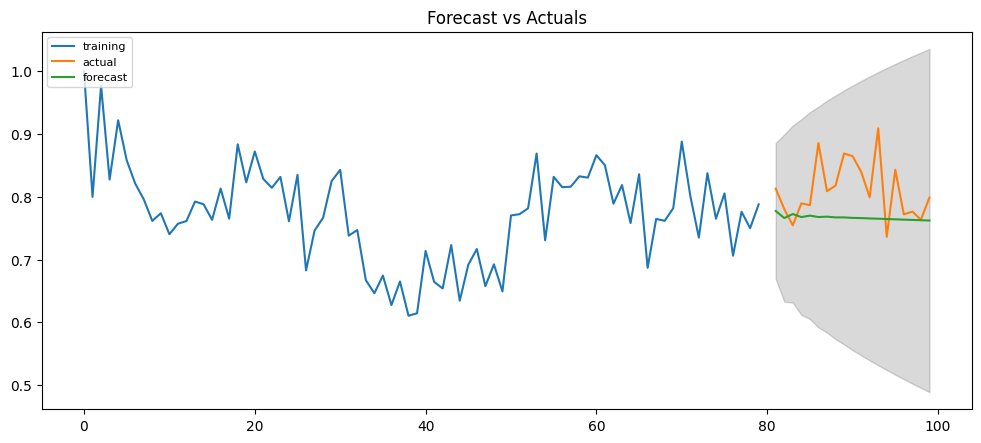

In [36]:

# Setup forecasts
nforecasts = 3
forecasts = {}

# Get the number of initial training observations
nobs = len(endog)
n_training = int(nobs * 0.8)
train = endog.iloc[:n_training]
test = endog.iloc[n_training+1:]
n_test = len(test)+1

# Create model for initial training sample, fit parameters
mod = sm.tsa.SARIMAX(train, order=(2, 0, 1))
res = mod.fit()

# Forecast
forecast = res.get_forecast(n_test, alpha=0.05, trend='c')  # 95% conf

# Make as pandas series
fc_series = pd.Series(forecast.predicted_mean, index=test.index)
conf = forecast.conf_int(alpha=0.05)
lower_series = pd.Series(conf.iloc[:,0], index=test.index)
upper_series = pd.Series(conf.iloc[:,1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#plt.plot(range(n-50),double_exp.time_series[50:n],label='original')
#res_plot = res.forecast(50)
##print(res_plot)
#plt.plot(range(n-50),res_plot,label='arma model')

#plt.legend()

In [37]:
ar2 = SARIMAX(train, order=(2,0,1), trend = 'c').fit()
print(ar2.summary())

                               SARIMAX Results                                
Dep. Variable:                      0   No. Observations:                   80
Model:               SARIMAX(2, 0, 1)   Log Likelihood                 121.974
Date:                Mon, 11 Apr 2022   AIC                           -233.948
Time:                        12:01:39   BIC                           -222.038
Sample:                             0   HQIC                          -229.173
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1241      0.066      1.876      0.061      -0.006       0.254
ar.L1          0.2443      0.161      1.517      0.129      -0.071       0.560
ar.L2          0.5979      0.122      4.897      0.0

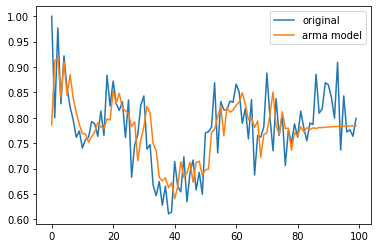

In [38]:
plt.plot(range(n),double_exp.time_series,label='original')
#plt.plot(range(n),double_res.time_series,label='reconstructed')
#double_nonoise = simpleTimeSeries(np.array([.8,.2]),0,np.array([1,0.4]),n,0)
#plt.plot(range(n),double_nonoise.time_series,label='original no noise')
##plt.plot(range(2,10),res_plot,label='ar model')
res_plot = ar2.predict(0,n-1)
plt.plot(range(0,n),res_plot,label='arma model')

plt.legend()

In [10]:
#res.predict(0,10)
res_plot = res.predict(2,9)
print(res_plot.shape)
t = range(2,10)
print(len(t))

(8,)
8


In [11]:
#double_res = simpleTimeSeries(np.array([-.0727,.5818]),0.3273,np.array([1,0.4]),n,0)
double_res = simpleTimeSeries(np.array([.2107,.7212]),0.0589,np.array([1,0.4]),n,0)
double_res = simpleTimeSeries(np.array([.1243,.8654]),0.0065,np.array([1,0.4]),n,0)

TypeError: __init__() missing 1 required positional argument: 'seed'

In [ ]:
plt.plot(range(1,10),double_exp.time_series[1:10],label='original')
plt.plot(range(1,10),double_res.time_series[1:10],label='reconstructed')
plt.plot(range(2,10),res_plot,label='ar model')
#plt.plot(range(2,n),res.predict(3,n),label='ar model')

plt.legend()

In [ ]:
plt.plot(range(n),double_exp.time_series,label='original')
#plt.plot(range(n),double_res.time_series,label='reconstructed')
#double_nonoise = simpleTimeSeries(np.array([.8,.2]),0,np.array([1,0.4]),n,0)
#plt.plot(range(n),double_nonoise.time_series,label='original no noise')
##plt.plot(range(2,10),res_plot,label='ar model')
res_plot = res.predict(5,n-1)
plt.plot(range(5,n),res_plot,label='ar model')

plt.legend()

In [ ]:
print(double_nonoise.time_series[99])
endog = pd.DataFrame(data_series,index=range(n))
# Setup forecasts
nforecasts = 3
forecasts = {}

# Get the number of initial training observations
nobs = len(endog)
n_init_training = int(nobs * 0.8)

# Create model for initial training sample, fit parameters
training_endog = endog.iloc[:n_init_training]
mod = sm.tsa.SARIMAX(training_endog, order=(1, 0, 0), trend='n')
res = mod.fit()

# Save initial forecast
forecasts[training_endog.index[-1]] = res.forecast(steps=nforecasts)

# Step through the rest of the sample
for t in range(n_init_training, nobs):
    # Update the results by appending the next observation
    updated_endog = endog.iloc[t:t+1]
    res = res.extend(updated_endog)

    # Save the new set of forecasts
    forecasts[updated_endog.index[0]] = res.forecast(steps=nforecasts)

# Combine all forecasts into a dataframe
forecasts = pd.concat(forecasts, axis=1)

print(forecasts.iloc[:5, :5])print(double_res.time_series[99])

In [ ]:


##res = AutoReg(simple_exp.time_series,1).fit()
#res = AutoReg(double_exp.time_series[0:50],2).fit()
#print(res.summary())